In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata as ud

Loads title.akas.tsv data. This file contains where each movie in the dataset has been released. The region of release is given by a two- or three-character country code.

In [3]:
title_akas = pd.read_csv('/Users/seankamano/Downloads/title.akas.tsv', delimiter = '\t', encoding = 'utf-8')
print title_akas.head(10)

/Users/seankamano/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


     titleId  ordering                      title region language  \
0  tt0000001         1  Carmencita - spanyol tánc     HU       \N   
1  tt0000001         2                 Карменсита     RU       \N   
2  tt0000001         3                 Carmencita     US       \N   
3  tt0000001         4                 Carmencita     \N       \N   
4  tt0000002         1     Le clown et ses chiens     \N       \N   
5  tt0000002         2          A bohóc és kutyái     HU       \N   
6  tt0000002         3     Le clown et ses chiens     FR       \N   
7  tt0000002         4     The Clown and His Dogs     US       \N   
8  tt0000002         5         Клоун и его собаки     RU       \N   
9  tt0000003         1            Szegény Pierrot     HU       \N   

         types             attributes isOriginalTitle  
0  imdbDisplay                     \N               0  
1           \N                     \N               0  
2           \N                     \N               0  
3     original  

Need to load title.basics.tsv data to get movies only. Gets tconst for all movies.

In [4]:
title_basics = pd.read_csv('/Users/seankamano/Downloads/title.basics.tsv', delimiter='\t', encoding='utf-8')
title_basics_movie = title_basics[title_basics['titleType'] == 'movie']
uid = title_basics_movie['tconst']

print uid.head(10)

/Users/seankamano/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


8      tt0000009
145    tt0000147
332    tt0000335
499    tt0000502
571    tt0000574
611    tt0000615
626    tt0000630
669    tt0000675
670    tt0000676
673    tt0000679
Name: tconst, dtype: object


Get movies only from title.akas.tsv by taking the tconsts in uid and comparing them to the titleId's in title.akas.tsv. This filters out any entries that are not movies in title.akas.tsv

In [5]:
title_akas_movies = title_akas[title_akas['titleId'].isin(uid.values)]

print title_akas_movies.head(10)

        titleId  ordering                          title region language  \
46    tt0000009         1                     Miss Jerry     \N       \N   
47    tt0000009         2                     Miss Jerry     HU       \N   
48    tt0000009         3                     Miss Jerry     US       \N   
568   tt0000147         1  The Corbett-Fitzsimmons Fight     US       \N   
971   tt0000335         1        Early Christian Martyrs     AU       \N   
972   tt0000335         2          Soldiers of the Cross     AU       \N   
973   tt0000335         3          Soldiers of the Cross     \N       \N   
1447  tt0000502         1                       Bohemios     ES       \N   
1663  tt0000574         1     Kelly bandájának története     HU       \N   
1664  tt0000574         2    The Story of the Kelly Gang     \N       \N   

            types attributes isOriginalTitle  
46       original         \N               1  
47    imdbDisplay         \N               0  
48             \N     

Remove movies without any regional data. Store movies without regional data for later reference, if it's ever needed.

In [7]:
title_akas_movies_by_region = title_akas_movies[title_akas_movies['region'] != '\N']
title_akas_movies_no_region = title_akas_movies[title_akas_movies['region'] == '\N']
print "Movies that have a region code:"
print title_akas_movies_by_region['region'].head(10)
print '\n',"*"*100,'\n'
print "Movies without a region code:"
print title_akas_movies_no_region['region'].head(10)

Movies that have a region code:
47      HU
48      US
568     US
971     AU
972     AU
1447    ES
1663    HU
1665    DE
1666    AU
1783    AU
Name: region, dtype: object

**************************************************************************************************** 

Movies without a region code:
46      \N
973     \N
1664    \N
1821    \N
2138    \N
2221    \N
2321    \N
2330    \N
2420    \N
2638    \N
Name: region, dtype: object


Need to make sense of region codes. Scrape data off of https://help.imdb.com/article/contribution/other-submission-guides/country-codes/G99K4LFRMSC37DCN#, which shows which country code corresponds to which country name. The BeautifulSoup and urllib2 modules are used here. The documentation for each can be found here https://docs.python.org/2/library/urllib2.html and here https://www.crummy.com/software/BeautifulSoup/bs4/doc/.

In [38]:
import urllib2
from bs4 import BeautifulSoup

soup = BeautifulSoup(urllib2.urlopen('https://help.imdb.com/article/contribution/other-submission-guides/country-codes/G99K4LFRMSC37DCN#').read(), "lxml")

# `tableClassResults` stores each line of HTML text which is contained by the object `table`. BeautifulSoup then
#  looks only for tables with the key `summary` which has a value of `List of accepted ...` and then stores all
#  of the HTML text enclosed within this specific table.

tableClassResults = soup.find("table",{"summary":"List of accepted country codes - by country"})

# find_all('li') finds all instances of <li> [desired info here] </li> in tableClassResults and stores 
# every [desired info here] into `countries` which is a list whose elements are a single line of HTML text.

countries = tableClassResults.find_all('li')
other_countries = soup.find_all('tr')
# other_countries contains codes for countries which no longer exist (USSR, Yugoslavia, etc.)

# `list_countries` is a list of all country names. The line below specifies that only the fourth character and on 
#  is all that's desired in each line of `countries`. List_codes works in the same exact way.
list_countries = [ud.normalize('NFKD', country.contents[0][4:]).encode('ascii','ignore') for country in countries]
list_codes = [str(country.contents[0][0:2]).upper() for country in countries]
other_countries = other_countries[-5:]
for country in other_countries:
    list_codes.append(str(country.contents[0])[4:8].upper())
for country in other_countries:
    list_countries.append(str(country.contents[1]))
print list_countries[:10]
print list_codes[:10]

['Afghanistan', 'Aland Islands', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica', 'Antigua and Barbuda']
['AF', 'AX', 'AL', 'DZ', 'AS', 'AD', 'AO', 'AI', 'AQ', 'AG']


Zip codes with country names so we have a reference for what each two-character acronym represents.

In [39]:
country_dict = dict(zip(list_codes,list_countries))

# Just print countries whose codes begin with the letter 'A'
for key in country_dict:
    if key[0] == 'A':
        print key,country_dict[key]


AF Afghanistan
AW Aruba
AE United Arab Emirates
AD Andorra
AG Antigua and Barbuda
AI Anguilla
AM Armenia
AL Albania
AO Angola
AN Netherlands Antilles
AQ Antarctica
AS American Samoa
AR Argentina
AU Australia
AT Austria
AX Aland Islands
AZ Azerbaijan


We now a more recognizable form for each country code. Now to find how many movies have been released in each country. 

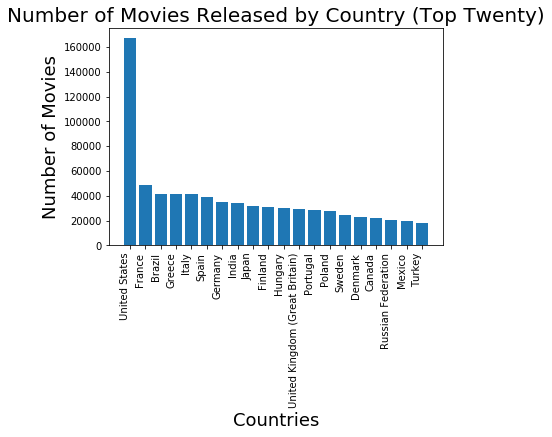

In [44]:
movies_per_country = dict(zip(list_codes, [0 for i in range(len(list_codes))]))
for code in title_akas_movies_by_region['region']:
    try:
        movies_per_country[str(code)] += 1
    except(KeyError):
        continue

top_ten_countries = []
top_ten_num_movies = []
top_ten_countries = sorted(movies_per_country, key=movies_per_country.get, reverse=True)[:20]
for code in top_ten_countries:
    top_ten_num_movies.append(movies_per_country[code])
for i in range(len(top_ten_countries)):
    top_ten_countries[i] = country_dict[top_ten_countries[i]]
fig, ax = plt.subplots()

ax.bar(np.arange(len(top_ten_countries)), top_ten_num_movies)

ax.set_title('Number of Movies Released by Country (Top Twenty)', fontsize=20)
ax.set_xlabel('Countries', fontsize=18)
ax.set_ylabel('Number of Movies', fontsize=18)

plt.xticks(np.arange(len(top_ten_countries)), top_ten_countries)
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()


Now for the average rating of all movies seen by a given country. Need title.ratings.tsv, extract movies with regional codes from it, and then attach a rating to each title.

In [12]:
title_ratings = pd.read_csv('/Users/seankamano/Downloads/title.ratings.tsv', delimiter='\t', encoding='utf-8')
title_ratings.head(10)

,tconst,averageRating,numVotes
0,tt0000001,5.8,1350
1,tt0000002,6.5,157
2,tt0000003,6.6,933
3,tt0000004,6.4,93
4,tt0000005,6.2,1621
5,tt0000006,5.7,80
6,tt0000007,5.5,543
7,tt0000008,5.6,1441
8,tt0000009,5.4,62
9,tt0000010,6.9,4845


Get the tconsts in title.ratings.tsv. Key-value pairs are made with the tconst as the key and average rating as the value and these pairs are stored in a dictionary. This dictionary will be used later to access rating data by tconst. Another dictionary will store tconst-country code pairs, so it will then be possible to pair rating data with country codes because a given rating and country code will have a common tconsnt as a key. 

In [13]:
tconsts = title_ratings['tconst'].values
ratings = title_ratings['averageRating'].values
tconst_rating_pairs = dict(zip(tconsts,ratings))
i = 0
for key in tconst_rating_pairs:
    if i == 10:
        break
    i += 1
    print key, tconst_rating_pairs[key]

tt7763324 7.2
tt1810373 7.1
tt1810372 7.5
tt1810371 7.2
tt0411539 6.2
tt0411538 7.9
tt2877896 8.5
tt0382269 4.8
tt3393762 7.5
tt0382267 7.2


Get all movies with a valid region and cross reference with movies which have an average rating. This gives us movies for which there are data for both region and ratings. This must be done since we are using movies from two different files.

In [14]:
movies_region_and_rating = title_akas_movies_by_region[title_akas_movies_by_region['titleId'].isin(tconsts)]
movies_region_and_rating.head(10)

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
47,tt0000009,2,Miss Jerry,HU,\N,imdbDisplay,\N,0
48,tt0000009,3,Miss Jerry,US,\N,\N,\N,0
568,tt0000147,1,The Corbett-Fitzsimmons Fight,US,\N,\N,\N,0
971,tt0000335,1,Early Christian Martyrs,AU,\N,working,\N,0
972,tt0000335,2,Soldiers of the Cross,AU,\N,\N,\N,0
1663,tt0000574,1,Kelly bandájának története,HU,\N,imdbDisplay,\N,0
1665,tt0000574,3,Die Geschichte der Kelly Bande,DE,\N,\N,\N,0
1666,tt0000574,4,The Story of the Kelly Gang,AU,\N,\N,\N,0
1783,tt0000615,1,Robbery Under Arms,AU,\N,\N,\N,0
1820,tt0000630,1,Amleto,IT,\N,\N,\N,0


We need to get ratings and connect them to country codes. First get ratings from title.ratings.tsv and attach them with their respective tconsts. Then, by comparing tconsts with titleId in movies_region_and_rating, we can get the country code. The ratings and region codes now have their tconsts in common, and we can now get data on ratings by country. We start by pairing tconsts and region codes as key-value pairs in a dictionary.

In [18]:
titleIds = movies_region_and_rating['titleId'].values
regions = movies_region_and_rating['region'].values
titleId_region_pairs = dict(zip(titleIds,regions))
j = 0
for key in titleId_region_pairs:
    if j == 10:
        break
    j += 1
    print key, titleId_region_pairs[key]

tt4340720 GB
tt0248097 MX
tt3060650 CA
tt0248093 DE
tt1677656 PK
tt0248099 US
tt1883133 FI
tt4557916 US
tt6788720 TH
tt3393762 US


Next, we do the same for ratings. A dictionary is intitialized with country codes as keys and average ratings as values. Next, tconsts are retrieved from the dataframe containing the tconsts for which regional and rating data exists. Each tconst is used to access its own rating value from the tconst-rating dictionary as well as its country code from the tconst-region dictionary above. Two dictionaries are initialized to hold the results: ratings_per_country_stats and ratings_per_country. Each of these dictionaries uses a country code as a key. The former has a two-element list as its value; the first element is the sum of average ratings of each movie released in that country, and the second element is the number of movies which had received ratings in that country. The latter has the average rating of all movies released in that country and is calculated by dividing the sum of average ratings and number of movies which had received ratings. 

In [20]:
ratings_per_country_stats = dict(zip(list_codes, [[0,0] for i in range(len(list_codes))]))
ratings_per_country = dict(zip(list_codes, [0 for i in range(len(list_codes))]))
for tcode in movies_region_and_rating['titleId']:
    try:
        tmp_rating = tconst_rating_pairs[tcode] 
        tmp_ccode = titleId_region_pairs[tcode]
        ratings_per_country_stats[tmp_ccode][0] += tmp_rating
        ratings_per_country_stats[tmp_ccode][1] += 1
    except KeyError:
        continue

for key in ratings_per_country:
    if ratings_per_country_stats[key][1] != 0:
        ratings_per_country[key] = ratings_per_country_stats[key][0] / ratings_per_country_stats[key][1]
    else:
        continue

print "Average Rating of All Movies in a Country\n"
for key in ratings_per_country:
    if key[0] == 'A':
        print key,ratings_per_country[key]

print '*'*100
print "\n[Sum of average ratings, number of movies with ratings] by Country"
for key in ratings_per_country_stats:
    if key[0] == 'A':
        print key,ratings_per_country_stats[key]

Average Rating of All Movies in a Country

AF 7.3
AW 7.2
AE 6.90243902439
AD 0
AG 7.66666666667
AI 0
AM 5.97109375
AL 6.56267409471
AO 6.73333333333
AN 8.8
AQ 0
AS 0
AR 6.46875083233
AU 6.35048785154
AT 6.57792853444
AX 0
AZ 7.3725848564
****************************************************************************************************

[Sum of average ratings, number of movies with ratings] by Country
AF [204.40000000000003, 28]
AW [14.4, 2]
AE [282.99999999999994, 41]
AD [0, 0]
AG [23.0, 3]
AI [0, 0]
AM [764.30000000000018, 128]
AL [2355.9999999999964, 359]
AO [40.399999999999999, 6]
AN [8.8000000000000007, 1]
AQ [0, 0]
AS [0, 0]
AR [97147.700000000987, 15018]
AU [33193.999999999927, 5227]
AT [63509.900000000103, 9655]
AX [0, 0]
AZ [2823.7000000000035, 383]


http://geojson.io/#map=3/34.52/-71.89